In [1]:
#library
import os
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# utils.py
def view_samples(samples, epochs, nrows=6, ncols=6, figsize=(5, 5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for img, ax in zip(samples[epochs], axes.flatten()):
        # To view a image, modify the range of image values to [0, 255]
        img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
        
def download():
    # before call the download function(), 
    # make the directory called data in order to save the SVHN data set
    data_dir = './data'
    if not os.path.isdir(data_dir):
        raise Exception("Directory doesn't exist")
    
    if not os.path.isfile(os.path.join(data_dir, 'train_32x32.mat')):
        urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat', 
                    os.path.join(data_dir, 'train_32x32.mat'))
    
    if not os.path.isfile(os.path.join(data_dir, 'test_32x32.mat')):
        urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat', 
                    os.path.join(data_dir, 'test_32x32.mat'))
    
    # SVHN data set
    train_set = loadmat(os.path.join(data_dir, 'train_32x32.mat'))
    test_set = loadmat(os.path.join(data_dir, 'test_32x32.mat'))
    
    return train_set, test_set

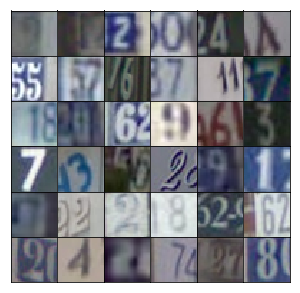

In [28]:
trainset, testset = download()
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)

The mission of the model is to predict the numbers from 0 to 9. Looking at the images in the SVHN dataset, the numbers doesn't consist of only single digit. The SVHN dataset have two digit and even three digit, even if the model predicts only single digit. In case of predicting the number in the image that consist of two digit or three digit, the middle number is the answer.

Let's look at the histogram to see how the data is distributed

Text(0.5,0,'value')

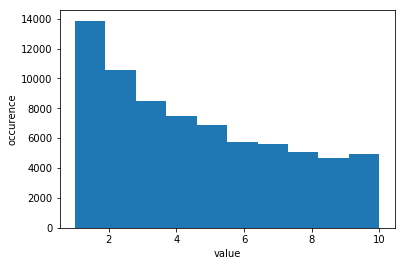

In [29]:
plt.hist(np.squeeze(trainset['y']), bins=10)
plt.ylabel('occurence')
plt.xlabel('value')

In [30]:
pd.Series(np.squeeze(trainset['y'])).value_counts()

1     13861
2     10585
3      8497
4      7458
5      6882
6      5727
7      5595
8      5045
10     4948
9      4659
dtype: int64

Looking at the histogram and value_counts, we can see two things

1. **Distribution of data is unbalanced** 
2. **0 isn't the correct answer**

*Unbalanced data*
>Looking at the data distribution through the histogram, data imbalance can be seen. A model only learns the image is real through unlabel data. But doesn't know exactly what the number is. Only through the label data, the model can only learn what the number is. Only 1,000 label data is used in a [Semi-supervised Learning with Deep Generative Models](https://https://arxiv.org/pdf/1406.5298.pdf). If the imbalance of the label data is severe, the model is difficult to learn the features of some numbers. Because of this, it is important for each class to consist of equally in the label data. So, set up 100 labels in the each class.

*the correct answer*
>the value_counts function, the label consist of 1 to 10, not 0 to 9. Change the 10 label to 1 label because I use **tf.one_hot**

In [31]:
# data.py
class Dataset:
    def __init__(self, train_set, test_set, shuffle=True):
        # the dataset that downloaded through the url, has the shape of (32, 32, 3, None)
        # change the shape of the dataset (None, 32, 32, 3) by using np.rollaxis
        train_set['X'] = np.rollaxis(train_set['X'], 3)
        train_set['y'] = np.squeeze(train_set['y'])
        test_set['X'] = np.rollaxis(test_set['X'], 3)
        test_set['y'] = np.squeeze(test_set['y'])
        
        # In data['y'], the 0 label is set to 10
        # To use tf.one_hot, the 10 label data is changed to 0
        train_set['y'][train_set['y'] == 10] = 0
        test_set['y'][test_set['y'] == 10] = 0
        
        self.train_x, self.train_y = train_set['X'], train_set['y']
        self.valid_x, self.test_x, self.valid_y, self.test_y = train_test_split(test_set['X'], test_set['y'], 
                                                                                test_size=0.5, random_state=0)
        
        self.label_mask = np.zeros_like(self.train_y)
        
        # change the each dataset value range using scale_func
        self.train_x = self.scale_func(self.train_x)
        self.valid_x = self.scale_func(self.valid_x)
        self.test_x = self.scale_func(self.test_x)
        
        # determine whether the dataset is mixed or not
        self.shuffle = shuffle
        
    def scale_func(self, x, value_range=(-1, 1)):
        min_value = value_range[0]
        max_value = value_range[1]
        
        # modify the range of image value to [-1, 1]
        return min_value + (max_value - min_value) * (x  - x.min()) / (x.max() - x.min())
    
    def batches(self, batch_size, which_set='train'):
        if which_set == 'train':
            # randomize the sequence of the train_x, train_y 
            # whenever the epochs start to prevent overfitting
            idx = np.arange(len(self.train_y))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
            
            # now, the ratio of each data is different
            # to match the amount of label data in each class equally, 
            # the amount of each label data was set to 100
            idx_list = np.array([])
            for i in range(10):
                idx_list = np.append(idx_list, np.where(self.train_y == i)[0][:100])
            for i in range(10):
                idx_list = np.append(idx_list, np.where(self.train_y == i)[0][100:])
            
            idx_list = idx_list.astype(np.int32).tolist()
            self.train_x = self.train_x[idx_list]
            self.train_y = self.train_y[idx_list]
            
            # label_mask is used to distinguish between label and unlabel by setting label data to 1
            self.label_mask[:] = 0
            self.label_mask[:1000] = 1

        name_x = which_set + '_x'
        name_y = which_set + '_y'
        num_examples = len(getattr(dataset, name_y))
        
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, name_x, getattr(dataset, name_x)[idx])
            setattr(dataset, name_y, getattr(dataset, name_y)[idx])
            if which_set == 'train':
                dataset.label_mask = dataset.label_mask[idx]
                
        data_x = getattr(dataset, name_x)
        data_y = getattr(dataset, name_y)
        
        for ii in range(0, num_examples, batch_size):
            x = data_x[ii:ii+batch_size]
            y = data_y[ii:ii+batch_size]
            if which_set == 'train':
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [32]:
# model.py
class GAN:
    def __init__(self):
        tf.reset_default_graph()
          
        # hyperparameter
        self.real_dim = (32, 32, 3)
        self.z_dim = 100
        self.alpha = 0.2
        self.smooth = 0.1
        self.epochs = 40
        self.batch_size = 128
        self.learning_rate = 0.0001
        self.show_result = 10
        self.model_path = './assets/model_epochs'
        
        model_input = self.model_input(self.real_dim, self.z_dim)
        self.input_real, self.input_z, self.target, self.label_mask, self.drop_rate, self.training = model_input
        self.d_loss, self.g_loss, self.correct, self.mask_correct = self.model_loss(self.training)
        self.d_opt, self.g_opt = self.model_optimizer()
    
    def model_input(self, real_dim, z_dim):
        input_real = tf.placeholder(tf.float32, [None, *real_dim], name='input_real')
        input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
        target = tf.placeholder(tf.int32, [None], name='target')
        label_mask = tf.placeholder(tf.int32, [None], name='label_mask')
        drop_rate = tf.placeholder(tf.float32, name='drop_rate')
        training = tf.placeholder(tf.bool, name='training')
        return input_real, input_z, target, label_mask, drop_rate, training
    
    def generator(self, z, out_dim, alpha=0.2, reuse=False, training=True, size_mult=32):
        with tf.variable_scope('generator', reuse=reuse):
            x1 = tf.layers.dense(z, (4 * 4 * size_mult * 4))
            x1 = tf.reshape(x1, (-1, 4, 4, size_mult*4))
            x1 = tf.layers.batch_normalization(x1, training=training)
            x1 = tf.maximum(x1, alpha*x1)
            
            # batch normalization includes gamma, beta variables that make the bias term unnecessary
            # so, when I use batch normalization, don't include the bias term
            x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same', use_bias=False)
            x2 = tf.layers.batch_normalization(x2, training=training)
            x2 = tf.maximum(x2, alpha*x2)
            
            x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same', use_bias=False)
            x3 = tf.layers.batch_normalization(x3, training=training)
            x3 = tf.maximum(x3, alpha*x3)
            
            logits = tf.layers.conv2d_transpose(x3, out_dim, 5, strides=2, padding='same', use_bias=False)
            out = tf.tanh(logits)
            
            return out
        
    def discriminator(self, x, alpha=0.2, reuse=False, training=True, size_mult=64, 
                      num_classes=10, extra_class=0, rate=0.5):        
        
        with tf.variable_scope('discriminator', reuse=reuse):
            # to prevent overfitting caused by using small set of label data,
            # use dropout on some layer.
            x = tf.layers.dropout(x, rate=rate/2.5)
            
            # 32x32x3 now
            x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
            x1 = tf.maximum(alpha*x1, x1)
            x1 = tf.layers.dropout(x1, rate=rate)
            
            # batch normalization includes gamma, beta variables that make the bias term unnecessary
            # so, when I use batch normalization, don't include the bias term
            x2 = tf.layers.conv2d(x1, size_mult, 3, strides=2, padding='same', use_bias=False)
            x2 = tf.layers.batch_normalization(x2, training=training)
            x2 = tf.maximum(alpha*x2, x2)
            
            x3 = tf.layers.conv2d(x2, size_mult, 3, strides=2, padding='same', use_bias=False)
            x3 = tf.layers.batch_normalization(x3, training=training)
            x3 = tf.maximum(alpha*x3, x3)
            x3 = tf.layers.dropout(x3, rate=rate)
            
            x4 = tf.layers.conv2d(x3, size_mult*2, 3, strides=1, padding='same', use_bias=False)
            x4 = tf.layers.batch_normalization(x4, training=training)
            x4 = tf.maximum(alpha*x4, x4)
            
            x5 = tf.layers.conv2d(x4, size_mult*2, 3, strides=1, padding='same', use_bias=False)
            x5 = tf.layers.batch_normalization(x5, training=training)
            x5 = tf.maximum(alpha*x5, x5)
            
            x6 = tf.layers.conv2d(x5, size_mult*2, 3, strides=1, padding='valid')
            x6 = tf.maximum(alpha*x6, x6)
            
            # unlike g_loss in the original gan,
            # define newly g_loss by using feature matching loss
            features = tf.reduce_mean(x6, (1, 2))
            
            # need the class_logits because I use the label data
            class_logits = tf.layers.dense(features, num_classes + extra_class)
            
            # depending on the extra_class value,
            # extra_class can be divided into two ways. 0 or 1
            if extra_class: # extra_class 1
                real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
                fake_class_logits = tf.squeeze(fake_class_logits)
            
            # in case of extra_class is equal to 0,
            # set the fake_class_logits to 0
            else: 
                real_class_logits = class_logits
                fake_class_logits = 0.
            
            # Preal = sum(softmax(real_classes)) = sigmoid(gan_logits)
            # calculate the gan_logits by using the equation that defined above
            m = tf.reduce_max(real_class_logits, axis=1, keep_dims=True)
            
            # calculate the m that is the largest in the real_class_logits, 
            # by subtracting m from real_class_logits, 
            # prevent real_class_logits from  growing larger and becoming unstable becauseof using tf.exp func
            stable_real_class_logits = real_class_logits - m
            gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + \
                            tf.squeeze(m) - fake_class_logits
            out = tf.nn.softmax(class_logits)
            return out, class_logits, gan_logits, features
            
    def model_loss(self, training, out_dim=3, num_classes=10, extra_class=0):
        g_size_mult = 32
        d_size_mult = 64
        
        g_out = self.generator(self.input_z, out_dim, alpha=self.alpha, size_mult=g_size_mult)
        
        def batch_training():
            return self.discriminator(self.input_real, self.alpha, size_mult=d_size_mult, rate=self.drop_rate)
        
        def batch_inference():
            return self.discriminator(self.input_real, self.alpha, reuse=True, training=False, 
                                      size_mult=d_size_mult, rate=self.drop_rate)
        
        d_real = tf.cond(training, batch_training, batch_inference)
        out_real, class_logits_real, gan_logits_real, features_real = d_real
        
        d_fake = self.discriminator(g_out, alpha=self.alpha, reuse=True, 
                                    size_mult=d_size_mult, rate=self.drop_rate)
        out_fake, class_logits_fake, gan_logits_fake, features_fake = d_fake
        
        # total data set includes label(real), unlabel(real) and imaginary(fake)
        # label data
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_real,
                                                                             labels=tf.ones_like(gan_logits_real)*
                                                                                                 (1-self.smooth))) 
        # imaginary data
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_fake,
                                                                             labels=tf.zeros_like(gan_logits_fake))) 
        # unlabel data
        self.target = tf.squeeze(self.target)
        class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_real,
                                                                      labels=tf.one_hot(self.target, 
                                                                                        num_classes+extra_class))
        # shape change. [batch_size, 1] -> [batch_size, ]
        class_cross_entropy = tf.squeeze(class_cross_entropy)
        label_mask = tf.squeeze(tf.cast(self.label_mask, tf.float32))
        
        # to prevent division by 0, use tf.maximum(1., tf.reduce_sum(label_mask))
        d_loss_class = tf.reduce_sum(class_cross_entropy * label_mask) / tf.maximum(1., tf.reduce_sum(label_mask))
        d_loss = d_loss_real + d_loss_fake + d_loss_class
        
        features_real = tf.reduce_mean(features_real, axis=0)
        features_fake = tf.reduce_mean(features_fake, axis=0)
        g_loss = tf.reduce_mean(tf.abs(features_real - features_fake))
        
        # Accuarcy
        pred_class = tf.cast(tf.argmax(class_logits_real, 1), tf.int32)
        equal = tf.equal(pred_class, self.target)
        correct = tf.reduce_sum(tf.cast(equal, tf.float32))
        mask_correct = tf.reduce_sum(label_mask * tf.cast(equal, tf.float32))
        
        return d_loss, g_loss, correct, mask_correct
    
    def model_optimizer(self):
        d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss, var_list=d_vars)
            g_opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss, var_list=g_vars)
            return d_opt, g_opt
        
    def model_train(self):
        samples, self.accuracy = [], []
        saver = tf.train.Saver()
        sample_z = np.random.normal(0, 1, size=(36, self.z_dim))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
    
            for e in range(self.epochs):
                # train data
                num_examples = 0
                num_correct = 0
                for x, y, label_mask in dataset.batches(self.batch_size):
                    num_examples += label_mask.sum()
                    batch_z = np.random.normal(0, 1, size=(36, self.z_dim))
                    
                    feed={self.input_real:x,
                          self.target:y,
                          self.input_z:batch_z,
                          self.label_mask:label_mask,
                          self.drop_rate:0.5,
                          self.training:True}
                    
                    _, _, mask_correct = sess.run([self.d_opt, self.g_opt, self.mask_correct], feed_dict=feed)
                    
                    num_correct += mask_correct
                
                train_accuracy = num_correct / float(num_examples)
                
                # valid_data
                num_examples = 0
                num_correct = 0
                for x, y in dataset.batches(self.batch_size, which_set='valid'):
                    num_examples += x.shape[0]
                    
                    feed = {self.input_real:x,
                            self.target:y,
                            self.drop_rate:0.,
                            self.training:False}
                    
                    correct = sess.run(self.correct, feed_dict=feed)
                    num_correct += correct
                    
                valid_accuracy = num_correct / float(num_examples)
                self.accuracy.append((train_accuracy, valid_accuracy))
                
                print('Epochs : {}'.format(e+1),
                      'Train Accuracy : {:.3f}'.format(train_accuracy), 
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy))
                
                if (e+1) % self.show_result == 0:
                    gen_samples = sess.run(self.generator(self.input_z, 3, reuse=True, training=False), 
                                           feed_dict={self.input_z:sample_z})
                    samples.append(gen_samples)
                    view_samples(samples, -1)
                    plt.show()

                    saver.save(sess, self.model_path, global_step=e)
        
        with open('./assets/samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    def model_test(self):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            num_correct = 0
            num_examples = 0 
            sample_z = np.random.uniform(-1, 1, size=(36, self.z_dim))
            saver.restore(sess, tf.train.latest_checkpoint('./assets/'))
            
            for x, y in dataset.batches(self.batch_size, which_set='test'):
                num_examples += x.shape[0]
                feed = {self.input_real:x,
                        self.target:y,
                        self.drop_rate:0.,
                        self.training:False}
                
                correct = sess.run(self.correct, feed_dict=feed)
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print('Test accuarcy: ', test_accuracy)
            
            gen_samples = sess.run(self.generator(self.input_z, 3, reuse=True, training=False), 
                                   feed_dict={self.input_z:sample_z})
            view_samples([gen_samples], -1)

Epochs : 1 Train Accuracy : 0.110 Valid Accuracy : 0.102
Epochs : 2 Train Accuracy : 0.121 Valid Accuracy : 0.120
Epochs : 3 Train Accuracy : 0.140 Valid Accuracy : 0.105
Epochs : 4 Train Accuracy : 0.167 Valid Accuracy : 0.133
Epochs : 5 Train Accuracy : 0.219 Valid Accuracy : 0.262
Epochs : 6 Train Accuracy : 0.254 Valid Accuracy : 0.293
Epochs : 7 Train Accuracy : 0.300 Valid Accuracy : 0.383
Epochs : 8 Train Accuracy : 0.354 Valid Accuracy : 0.400
Epochs : 9 Train Accuracy : 0.409 Valid Accuracy : 0.454
Epochs : 10 Train Accuracy : 0.458 Valid Accuracy : 0.468


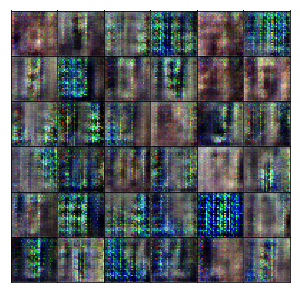

Epochs : 11 Train Accuracy : 0.478 Valid Accuracy : 0.485
Epochs : 12 Train Accuracy : 0.528 Valid Accuracy : 0.526
Epochs : 13 Train Accuracy : 0.527 Valid Accuracy : 0.539
Epochs : 14 Train Accuracy : 0.567 Valid Accuracy : 0.539
Epochs : 15 Train Accuracy : 0.578 Valid Accuracy : 0.604
Epochs : 16 Train Accuracy : 0.600 Valid Accuracy : 0.570
Epochs : 17 Train Accuracy : 0.618 Valid Accuracy : 0.616
Epochs : 18 Train Accuracy : 0.599 Valid Accuracy : 0.590
Epochs : 19 Train Accuracy : 0.636 Valid Accuracy : 0.654
Epochs : 20 Train Accuracy : 0.650 Valid Accuracy : 0.680


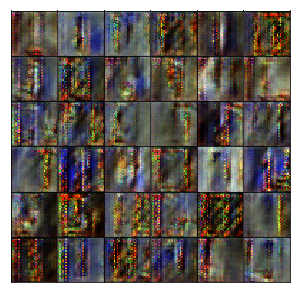

Epochs : 21 Train Accuracy : 0.651 Valid Accuracy : 0.609
Epochs : 22 Train Accuracy : 0.660 Valid Accuracy : 0.684
Epochs : 23 Train Accuracy : 0.693 Valid Accuracy : 0.665
Epochs : 24 Train Accuracy : 0.672 Valid Accuracy : 0.721
Epochs : 25 Train Accuracy : 0.728 Valid Accuracy : 0.683
Epochs : 26 Train Accuracy : 0.695 Valid Accuracy : 0.700
Epochs : 27 Train Accuracy : 0.723 Valid Accuracy : 0.713
Epochs : 28 Train Accuracy : 0.737 Valid Accuracy : 0.674
Epochs : 29 Train Accuracy : 0.709 Valid Accuracy : 0.726
Epochs : 30 Train Accuracy : 0.737 Valid Accuracy : 0.677


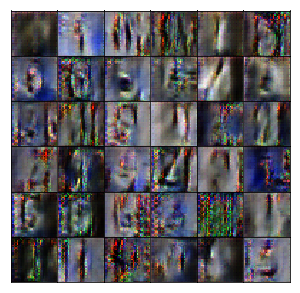

Epochs : 31 Train Accuracy : 0.732 Valid Accuracy : 0.703
Epochs : 32 Train Accuracy : 0.714 Valid Accuracy : 0.717
Epochs : 33 Train Accuracy : 0.710 Valid Accuracy : 0.742
Epochs : 34 Train Accuracy : 0.758 Valid Accuracy : 0.737
Epochs : 35 Train Accuracy : 0.745 Valid Accuracy : 0.743
Epochs : 36 Train Accuracy : 0.703 Valid Accuracy : 0.736
Epochs : 37 Train Accuracy : 0.747 Valid Accuracy : 0.764
Epochs : 38 Train Accuracy : 0.733 Valid Accuracy : 0.719
Epochs : 39 Train Accuracy : 0.715 Valid Accuracy : 0.740
Epochs : 40 Train Accuracy : 0.739 Valid Accuracy : 0.751


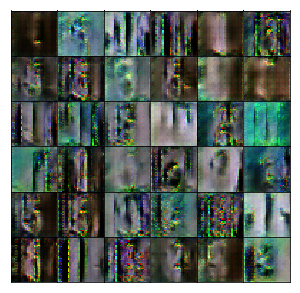

In [33]:
# main.py
dataset = Dataset(trainset, testset)
gan = GAN()
gan.model_train()

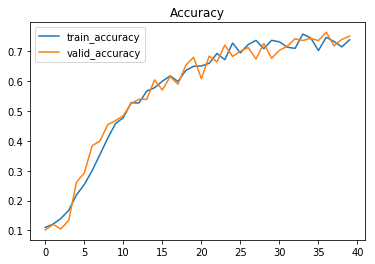

In [34]:
fig, ax = plt.subplots()
plt.plot(np.array(gan.accuracy).T[0], label='train_accuracy')
plt.plot(np.array(gan.accuracy).T[1], label='valid_accuracy')
plt.title('Accuracy')
plt.legend()

INFO:tensorflow:Restoring parameters from ./assets/model_epochs-39


INFO:tensorflow:Restoring parameters from ./assets/model_epochs-39


Test accuarcy:  0.750921942225


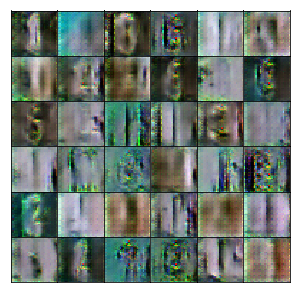

In [35]:
gan.model_test()

Looking at the images that the generator makes in test and final epoch, the shape of the each number can be seen faintly.
But, in the [Semi-supervised Learning with Deep Generative Models](https://arxiv.org/pdf/1406.5298.pdf), the generator makes clear number images. So, need to improve the performance of the generator by using the techniques that the paper introduce

## Unfinished part

1. **Train the model with only 1,000 label data fixed** - Whenever the epoch start, I changed the sequence of the label data in order to prevent overfitting from fixing the label data. Because of that, this isn't exact semi-supervised learning with gan. So I will train the model without changing the label data. 

2. **Raise the performance of the model** - In the [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf), They raise the performance of the model more than 90% even only 1,000 label data in the SVHN dataset. So using the techniques that are in the Improved techniques for training GANs, I will try to update the model